### We already had attention models which used a mechanism called attention, bwing able to access information about all the elements of the input sequence. It was able to extract information from the whole sequence, taking a weighted sum of all the past encoder states. 

But, this approach had a limitation, each sequence must be treated one element at a time. This was simply a computationally very expensive and time consuming process. 

## This resulted in creation of the transformer, a model architecture relying entirely on the attention mechanism. 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import drive

In [23]:
import math
import os
import gc
import time
import re

In [28]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [31]:

# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
NUM_SAMPLES = 80000 #40000
MAX_VOCAB_SIZE = 2**14

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.
MAX_LENGTH = 15



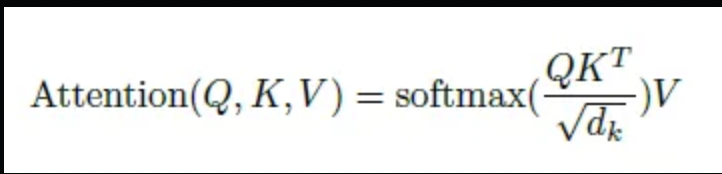

In [ ]:
def scaled_dot_product(queries,keys,values,mask):

  product=tf.matmul(queries,keys,transpose_b=True)

  keys_dim=tf.cast(tf.shape(keys)[-1],tf.float32)


  scaled_product=product/tf.math.sqrt(keys_dim)

  #Masking if required

  if mask is not None:
    scaled_product+=(mask*-1e9)

  attention=tf.matmul(tf.nn.softmax(scaled_product,axis=-1),values)

  return attention  

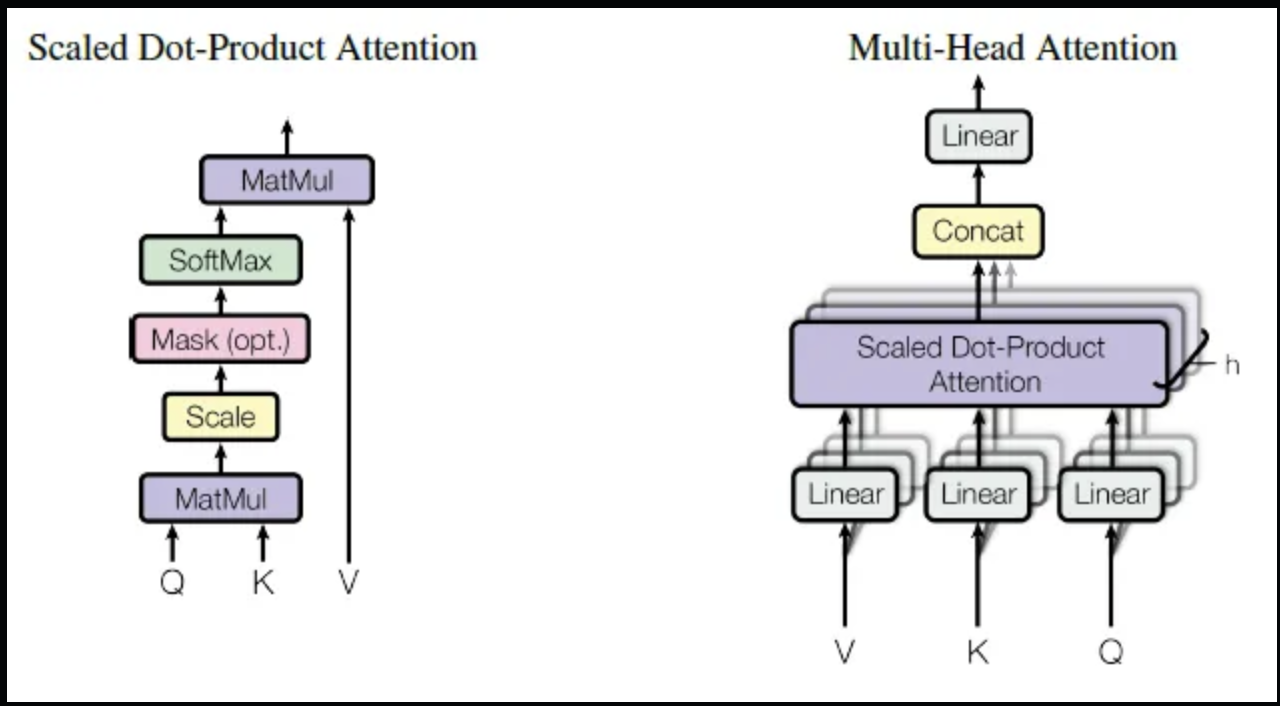

Next we add a concept of multi heads to the attention model because we want the model on different positions and not be dominated by the actual word only. 

And since the final FFNN is expecting a single neural network, we concatenate the outputs of all the heads before supplying it to the FFNN

In [ ]:
class MultiHeadAttention(layers.Layer):

  def __init__(self,n_heads):
    super(MultiHeadAttention,self).__init__() #Initializing the superclass
    self.n_heads=n_heads

  def build(self,input_shape):
    self.d_model=input_shape[-1]

    assert self.d_model%self.n_heads==0

    self.d_head=self.d_model//self.n_heads #Calculate the dimensions of every head
    self.query_lin=layers.Dense(units=self.d_model) #Q
    self.key_lin=layers.Dense(units=self.d_model)  #K
    self.value_lin=layers.Dense(units=self.d_model)  #V

    self.final_lin=layers.Dense(units=self.d_model)#W0 matrix


# divide the input vectors into smaller projected vectors to enable parallel processing for each head or projection
  def split_proj(self,inputs,batch_size):

    shape=(batch_size,-1,self.n_heads,self.d_heads)

    splited_inputs=tf.reshape(inputs,shape=shape)

    return tf.transpose(splited_inputs,perm=[0,2,1,3])


  def call(self,queries,keys,values,mask):

    batch_size=tf.shape(queries)[0]

    #Set the matrices
    queries=self.query_lin(queries)
    keys=self.key_lin(keys)
    values=self.values_lin(values)

    #Split for the multiple heads
    queries=self.split_proj(queries,batch_size)
    keys=self.split_proj(keys,batch_size)
    values=self.split_proj(values,batch_size)


    #Calculate the scaled product
    attention=scaled_dot_product(queries,keys,values,mask)


    #Get the score
    attention=tf.transpose(attention,perm=[0,2,1,3])


    #Concatenate for W0 matrix
    concat_attention=tf.reshape(attention,
                                shape=(batch_size,-1,self.d_model))
    
    outputs=self.final_lin(concat_attention)


    return outputs

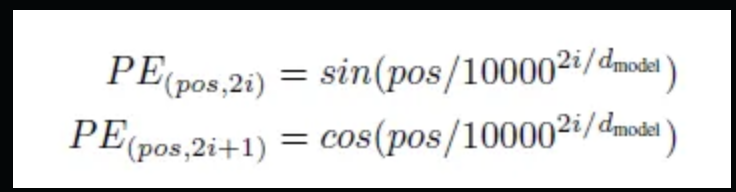

Positional encodings are being used because the self attention mod

In [ ]:
class PositionalEncoding(layers.Layer):


  def __init__(self):

    super(PositionalEncoding,self).__init__()


  def get_angles(self,pos,i,d_model):

    angles=1/np.power(1000.,(2*(i//2))/np.float32(d_model))
    return pos*angles

  #calculates the positional encodings based on the input tensor's shape and appends them to the input tensor. 
  def call(self,inputs):

        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        pos_encoding = angles[np.newaxis, ...]  


        return inputs+tf.cast(pos_encoding,tf.float32)  

# Encoder

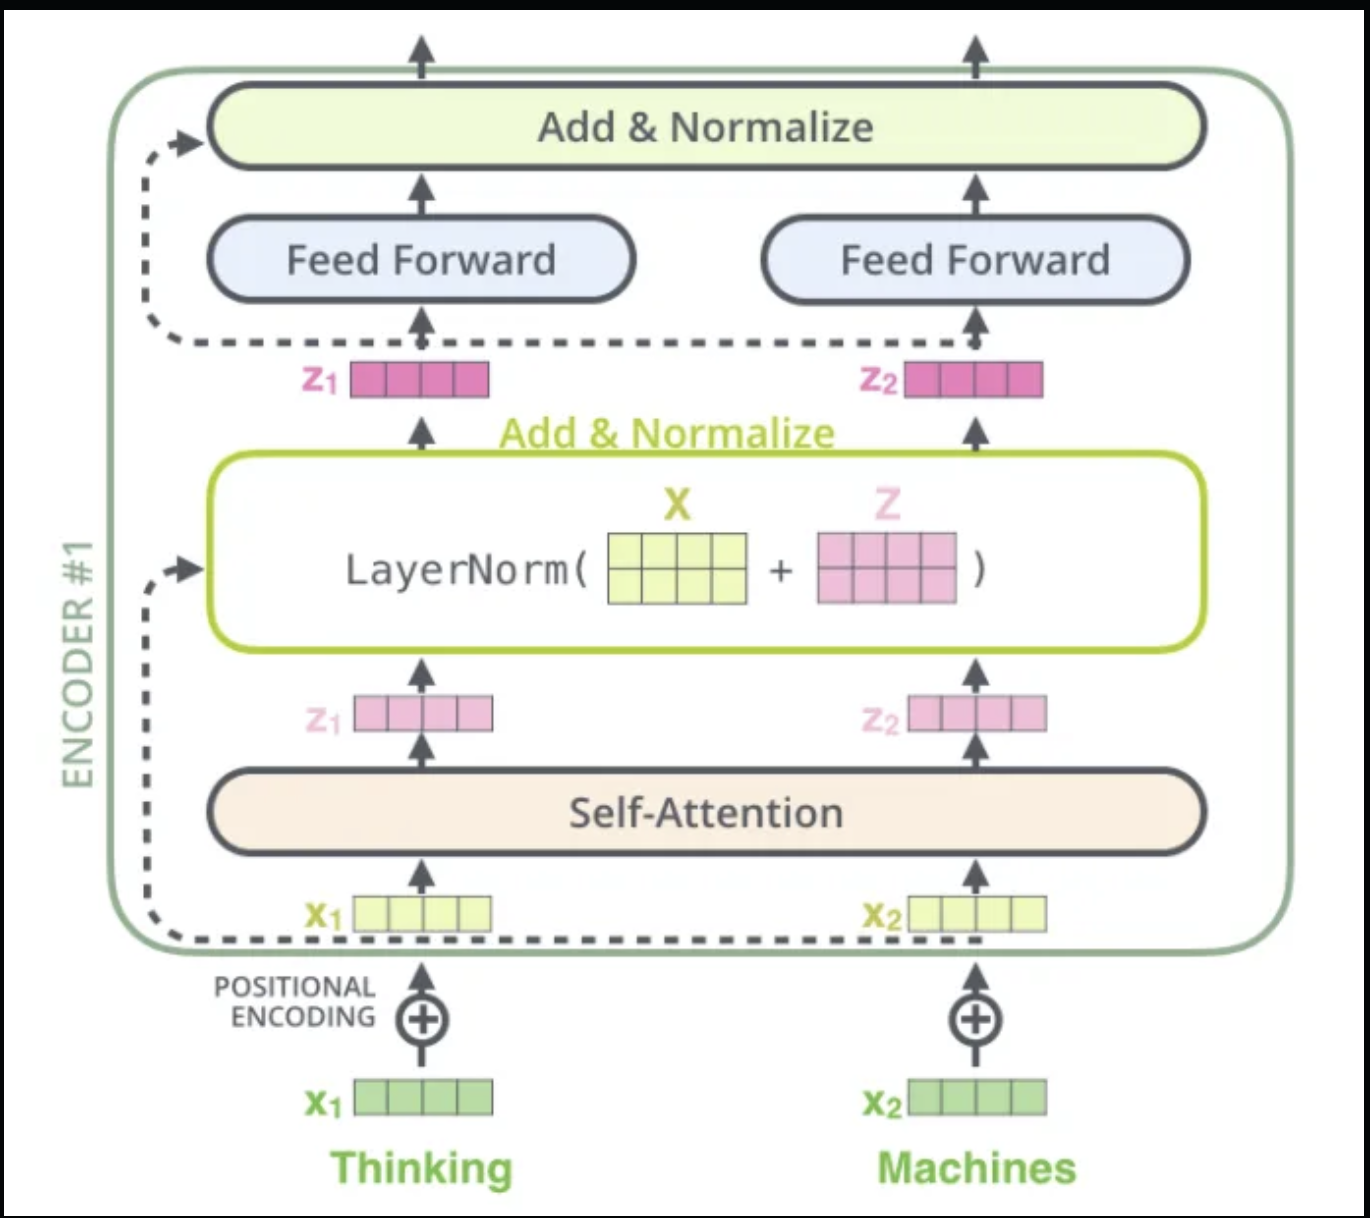

In [ ]:
class EncoderLayer(layers.Layer):
  def __init__(self,FFN_units,n_heads,dropout_rate):

    super(EncoderLayer,self).__init__()

    self.FFN_units=FFN_units

    self.n_heads=n_heads

    self.dropout_rate=dropout_rate



  def build(self,input_shape):
    self.d_model=input_shape[-1]

    self.multi_head_attention=MultiHeadAttention(self.n_head)
    self.dropout_1=layers.Dropout(rate=self.dropout_rate)

    self.norm_1=layers.LayerNormalization(epsilon=1e-6)

    self.ffn1_relu=layers.Dense(units=self.FFN_units,activation="relu")
    self.ffn2=layers.Dense(units=self.d_model)
    self.dropout_2=layers.Dropout(rate=self.dropout_rate)

    self.norm_2=layers.LayerNormalization(epsilon=1e-6)


  def call(self,inputs,mask,training):

    def cal(self,inputs,mask,training):

      attention=self.multi_head_attention(inputs,inputs,inputs,mask)

      attention=self.dropout_1(attention,training=training)

      attention=self.norm_1(attention + inputs)

      outputs=self.ffn1_relu(attention)
      outputs=self.ffn2(outputs)
      outputs=self.dropout_2(outputs,training=training)

      outputs=self.norm_2(outputs+attention)

      return outputs    

In [ ]:
class Encoder(layers.Layer):

  def __init__(self,
               n_layers,
               FFN_units,
               n_heads,
               dropout_rate,
               vocab_size,
               d_model,
               name="encoder"):
    super(Encoder,self).__init__(name=name)
    self.n_layers=n_layers
    self.d_model=d_model

    self.embedding=layers.Embedding(vocab_size,d_model)

    self.pos_encoding=PositionalEncoding()
    self.dropout=layers.Dropout(rate=dropout_rate)

    self.enc_layers=[EncoderLayer(FFN_units,
                                  n_heads,
                                  dropout_rate)
    for i in range(n_layers)]


  def call(self,inputs,mask,training):

    outputs=self.embedding(inputs)

    outputs *=tf.math.sqrt(tf.cast(self.d_model,tf.float32))

    outputs=self.pos_encoding(outputs)
    outputs=self.dropout(outputs,training)

    for i in range(self.n_layers):
      outputs=self.enc_layers[i](outputs,mask,training)


    return outputs    

# Decoder

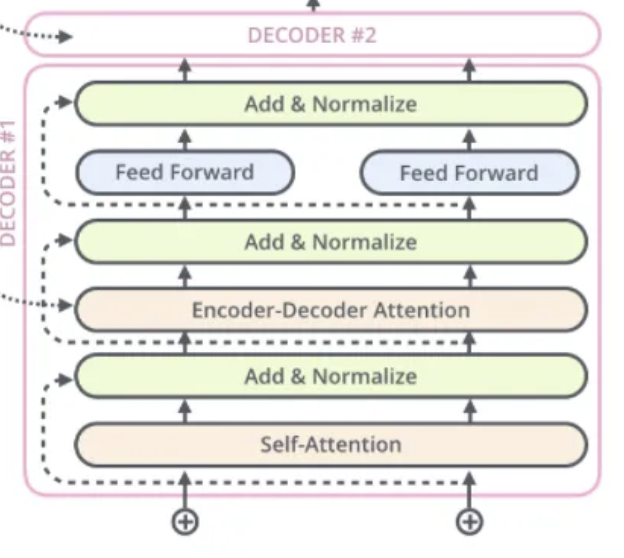

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.d_model = input_shape[-1]

        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)

        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        attention = self.multi_head_causal_attention(inputs, inputs, inputs, mask_1)
        attention = self.dropout_1(attention, training)
        attention = self.norm_1(attention + inputs)

        attention_2 = self.multi_head_enc_dec_attention(attention, enc_outputs, enc_outputs, mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        attention_2 = self.norm_2(attention_2 + attention)

        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        outputs = self.norm_3(outputs + attention_2)

        return outputs


In [ ]:
class Decoder(layers.Layer):

  def __init__(self,
               n_layers,
               FFN_units,
               n_heads,
               dropout_rate,
               vocab_size,
               d_model,
               name="decoder"):
    super(Decoder,self).__init__(name=name)
    self.d_model=d_model
    self.n_layers=n_layers

    self.embedding=layers.Embedding(vocab_size,d_model)

    self.pos_encoding=PositionalEncoding()
    self.dropout=layers.Dropout(rate=dropout_rate)

    self.dec_layers=[DecoderLayer(FFN_units,
                                  n_heads,
                                  dropout_rate)
    for i in range(n_layers)]


  def call(self,inputs,enc_outputs,mask_1,mask_2,training):

    outputs=self.embedding(inputs)

    outputs*=tf.math.sqrt(tf.cast(self.d_model,tf.float32))

    outputs=self.pos_encoding(outputs)
    outputs=self.dropout(outputs,training)

    for i in range(self.n_layers):
      outputs=self.dec_layers[i](outputs,
                                 enc_outputs,
                                 mask_1,
                                 mask_2,
                                 training)

    return outputs    

# Assembling the Transformer 🤖

In [ ]:
class Transformer(tf.keras.Model):

  def __init__(self,
               vocab_size_enc,
               vocab_size_dec,
               d_model,
               FFN_units,
               n_heads,
               dropout_rate,
               name="transformer"):
    super(Transformer,self).__init__(name=name)

    self.encoder=Encoder(n_layers,
                         FFN_units,
                         n_heads,
                         dropout_rate,
                         vocab_size_enc,
                         d_model)
    
    self.decoderr=Decoder(n_layers,
                         FFN_units,
                         n_heads,
                         dropout_rate,
                         vocab_size_enc,
                         d_model)
    
    self.last_linear=layers.Dense(units=vocab_size_dec,name="lin_output")

  def create_padding_mask(self,seq):

    mask=tf.cast(tf.math.equal(seq,0),tf.float32)
    return mask[:,tf.newaxis,tf.newaxis,:]

  def create_look_ahead_mask(self,seq):
    seq_len=tf.shape(seq)[1]
    look_ahead_mask=1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
    return look_ahead_mask

  def call(self,enc_inputs,dec_inputs,training):

    enc_mask=self.create_padding_mask(enc_inputs)

    dec_mask_1=tf.maximum(
        self.create_padding_mask(dec_inputs),
        self.create_look_ahead_mask(dec_inputs)
    )      

    dec_mask_2=self.create_padding_mask(enc_inputs)

    

    enc_outputs=self.encoder(enc_inputs,enc_mask,training)

    dec_outputs=self.decoder(dec_inputs,
                             enc_outputs,
                             dec_mask_1,
                             dec_mask_2,
                             training)
    
    outputs=self.last_linear(dec_outputs)

    return outputs

## Custom Loss Function

In [ ]:
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## Scheduler which varies the learning rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## Main Train Function

In [ ]:
def main_train(dataset, transformer, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Inicio del epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions = transformer(enc_inputs, dec_inputs, True)
            # Calculate the loss
            loss = loss_function(dec_outputs_real, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # Save and store the metrics
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Lote {} Pérdida {:.4f} Precisión {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    # Checkpoint the model on every epoch        
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} in {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time for 1 epoch: {} secs\n".format(time.time() - start))

  return losses, accuracies

In [ ]:

# Set hyperparamters for the model
D_MODEL = 512 # 512
N_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.1 # 0.1

In [ ]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model

transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Las checkpoint restored.")

# Train the model
losses, accuracies = main_train(dataset, transformer, EPOCHS)

TypeError: ignored

# Predictions

In [ ]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions = transformer(enc_input, output, False) #(1, seq_length, VOCAB_SIZE_ES)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [ ]:
def translate(sentence):
    # Get the predicted sequence for the input sentence
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    # Transform the sequence of tokens to a sentence
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence